### gQuant Tutorial
First import all the necessary modules.

In [1]:
import sys
sys.path.append('..')
import os
import warnings
import ipywidgets as widgets
from gquant.dataframe_flow import TaskGraph

warnings.simplefilter("ignore")

In this tutorial, we are going to use gQuant to do a simple quant job. The task is fully described in a yaml file

In [2]:
!head -n 31 ../task_example/simple_trade.yaml

- id: load_csv_data
  type: CsvStockLoader
  conf:
    path: ./data/stock_price_hist.csv.gz
  inputs: []
- id: node_assetFilter
  type: AssetFilterNode
  conf:
    asset: 22123
  inputs: 
    - load_csv_data
- id: node_sort
  type: SortNode
  conf:
    keys: 
      - asset
      - datetime
  inputs: 
    - node_assetFilter
- id: node_addReturn
  type: ReturnFeatureNode
  conf: {}
  inputs: 
    - node_sort
- id: node_ma_strategy
  type: MovingAverageStrategyNode
  conf:
      fast: 5
      slow: 10
  inputs: 
    - node_addReturn


The yaml file is describing the computation task by a graph, we can visualize it

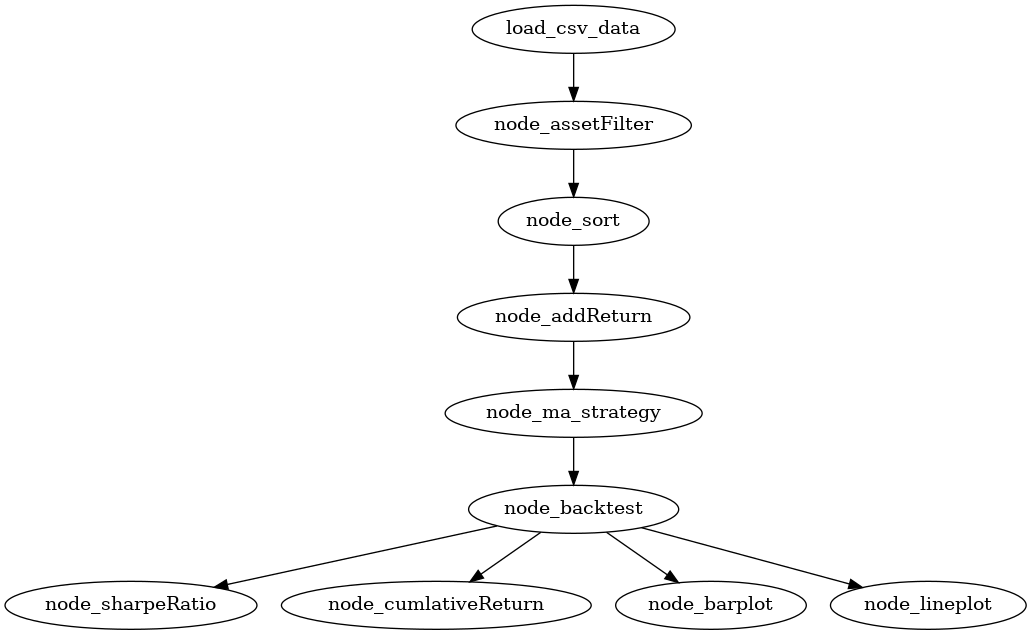

In [3]:
task_graph = TaskGraph.load_taskgraph('../task_example/simple_trade.yaml')
task_graph.draw(show='ipynb')

We define a method to organize the output images

In [4]:
def plot_figures(o, symbol):
    # format the figures
    figure_width = '1200px'
    figure_height = '400px'
    bar_figure = o[2]
    sharpe_number = o[0]
    cum_return = o[1]
    signals = o[3]

    bar_figure.layout.height = figure_height
    bar_figure.layout.width = figure_width
    cum_return.layout.height = figure_height
    cum_return.layout.width = figure_width
    cum_return.title = 'P & L %.3f' % (sharpe_number)
    bar_figure.marks[0].labels = [symbol]
    cum_return.marks[0].labels = [symbol]
    signals.layout.height = figure_height
    signals.layout.width = figure_width
    bar_figure.axes = [bar_figure.axes[1]]
    cum_return.axes = [cum_return.axes[0]]
    output = widgets.VBox([bar_figure, cum_return, signals])

    return output

We load the symbol name to symbol id mapping file:

In [5]:
node_stockSymbol = {"id": "node_stockSymbol",
                    "type": "StockNameLoader",
                    "conf": {"path": "./data/security_master.csv.gz"},
                    "inputs": []}
name_graph = TaskGraph([node_stockSymbol])
list_stocks = name_graph.run(outputs=['node_stockSymbol'])[0].to_pandas().set_index('asset_name').to_dict()['asset']

Evaluate the output nodes and plot the results:

In [6]:
symbol = 'REXX'
action = "load" if os.path.isfile('./.cache/load_csv_data.hdf5') else "save"
o = task_graph.run(
            outputs=['node_sharpeRatio', 'node_cumlativeReturn',
                     'node_barplot', 'node_lineplot', 'load_csv_data'],
            replace={'load_csv_data': {action: True},
                     'node_barplot': {'conf': {"points": 300}},
                     'node_assetFilter':
                         {'conf': {'asset': list_stocks[symbol]}}})
cached_input = o[4]
plot_figures(o, symbol)

Change the strategy parameters

In [7]:
o = task_graph.run(
            outputs=['node_sharpeRatio', 'node_cumlativeReturn',
                     'node_barplot', 'node_lineplot'],
            replace={'load_csv_data': {"load": cached_input},
                     'node_barplot': {'conf': {"points": 200}},
                     'node_ma_strategy': {'conf': {'fast': 1, 'slow': 10}},
                     'node_assetFilter': {'conf': {'asset': list_stocks[symbol]}}})
figure_combo = plot_figures(o, symbol)
figure_combo

In [8]:
add_stock_selector = widgets.Dropdown(options=list_stocks.keys(),
                                      value=None, description="Add stock")
para_selector = widgets.IntRangeSlider(value=[10, 30],
                                       min=3,
                                       max=60,
                                       step=1,
                                       description="MA:",
                                       disabled=False,
                                       continuous_update=False,
                                       orientation='horizontal',
                                       readout=True)


def para_selection(*stocks):
    with out:
        symbol = add_stock_selector.value
        para1 = para_selector.value[0]
        para2 = para_selector.value[1]
        o = task_graph.run(
                    outputs=['node_sharpeRatio', 'node_cumlativeReturn',
                             'node_barplot', 'node_lineplot'],
                    replace={'load_csv_data': {"load": cached_input},
                             'node_barplot': {'conf': {"points": 200}},
                             'node_ma_strategy': {'conf': {'fast': para1, 'slow': para2}},
                             'node_assetFilter': {'conf': {'asset': list_stocks[symbol]}}})
        figure_combo = plot_figures(o, symbol)
        if (len(w.children) < 2):
            w.children = (w.children[0], figure_combo,)
        else:
            w.children[1].children[1].marks = figure_combo.children[1].marks
            w.children[1].children[2].marks = figure_combo.children[2].marks
            w.children[1].children[1].title = 'P & L %.3f' % (o[0])


out = widgets.Output(layout={'border': '1px solid black'})
add_stock_selector.observe(para_selection, 'value')
para_selector.observe(para_selection, 'value')
selectors = widgets.HBox([add_stock_selector, para_selector])
w = widgets.VBox([selectors])
w